In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
import random
import time
import csv
import math

In [2]:
def exact_netx(graph):
  start = time.time()
  t = sum(nx.triangles(graph).values())/3
  end = time.time()
  return {"triangles": t, "time": end - start}

In [3]:
def exact_trace(graph):
  start = time.time()
  adj_matrix = nx.adjacency_matrix(graph, dtype = np.float64)
  adj_matrix_cubed = adj_matrix @ adj_matrix @ adj_matrix
  print(adj_matrix_cubed.trace())
  t = adj_matrix_cubed.trace()/6
  end = time.time()
  return {"triangles": t, "time": end - start}

In [4]:
def uniform_sampling(graph, sample_size):
  start = time.time()
  nodes = list(graph.nodes)
  n = len(nodes)
  node_sample = random.sample(nodes, sample_size)
  sample_t = 0
  for node in node_sample:
    sample_t += nx.triangles(graph, node)
  sample_t /= 3
  t = sample_t*n/sample_size
  end = time.time()
  return {"triangles": t, "time": end - start}

In [5]:
def random_sampling_with_degrees(graph, sample_size):
  start = time.time()
  nodes = []
  degrees = []
  sum_of_degrees=0
  for node in graph:
    nodes.append(node)
    degree=graph.degree(node)
    degrees.append(degree)
    sum_of_degrees+=degree
  node_sample = random.choices(nodes, weights = degrees, k = sample_size)
  sample_t = 0
  for node in node_sample:
    sample_t += nx.triangles(graph, node)/graph.degree(node)
  t = (sample_t*sum_of_degrees/3)*(1/sample_size)
  end = time.time()
  return {"triangles": t, "time": end - start}

 

In [6]:
def hutch(graph, trials):
    start = time.time()
    adj = nx.adjacency_matrix(graph, dtype = np.float64)
    adj = adj.toarray()
    d = adj.shape[0]
    total = 0
    for _ in range(trials):
        v = np.random.choice([-1,1], d)
        tr = np.transpose(v) @ (adj @ (adj @ (adj @ v)))
        total += tr
    total/=trials
    end = time.time()
    return {"triangles" : total/6, "time": end-start, "trials": trials}

In [7]:
def hutchplusplus(graph, queries):
    start = time.time()
    A = nx.adjacency_matrix(graph, dtype = np.float64)
    d = A.shape[0]
    S = np.random.choice([1, -1], size = (d, queries//3))
    G = np.random.choice([1, -1], size = (d, queries//3))
    Q, R = np.linalg.qr(A @ (A @ (A @ S)))
    term_1 = np.trace(Q.T @ (A @ (A @ (A @ Q))))
    term_prod = G - Q @ (Q.T @ G)
    term_2 = 3/queries*np.trace(term_prod.T @ (A @ (A @ (A @ term_prod))))
    t = term_1/6 + (term_2 - term_1)/6
    end = time.time()
    return {"triangles": t, "time": end - start}

In [8]:
# def lanczos(A, m):
#     n = A.shape[0]
#     v = [np.random.rand(n)]
#     w_prime = [A @ v[0]]
#     alpha = [w_prime[0] * v[0]]
#     beta = []
#     w = [w_prime[0] - alpha[0] @ v[0]]
#     for j in range(2, m + 1):
#         beta_j = np.linalg.norm(w[-1])
#         beta.push(beta_j)
#         if beta_j != 0:
#             v_j = w[-1]/beta_j
#         else:
#             v_j = #TODO
#         v.push(v_j)
#         w_prime.push(A @ v[-1])
#         alpha.push(w_prime[-1]*v[-1])


In [9]:
# def eigenTriangle(graph, sample_size, tol):
#   adj_matrix = nx.adjacency_matrix(graph, dtype = np.float64)
#   nodes = list(graph.nodes)
#   n = len(nodes)
#   node_sample = random.sample(nodes, sample_size)
#   for node in node_sample:
#     lambda_1 = lanczos(A, 1)
#     eigen = lambda_1
#     i = 2

In [10]:
fb = nx.read_edgelist('facebook_combined.txt', create_using = nx.Graph(), nodetype = int)
nnodes_fb = fb.number_of_nodes()
ntriangles = nx.triangles(fb, 0)
exact_networkx_metrics = exact_netx(fb)
print(exact_networkx_metrics)
# hutch_count = hutch(fb)
# print(hutch_count)
# exact_trace_metrics = exact_trace(fb)
# print(exact_trace_metrics)

# uniform_sampling_metrics = uniform_sampling(fb, 404)
# print(uniform_sampling_metrics)
# rel_error = abs(ntriangles - uniform_sampling_metrics['triangles'])/ntriangles
# print(rel_error)

{'triangles': 1612010.0, 'time': 2.863084077835083}


In [11]:
def repeat_weighted(n):
    for i in range(n):
        weighted_sampling_metrics = random_sampling_with_degrees(fb, 404)
        print(weighted_sampling_metrics)
        rel_error = abs(ntriangles - weighted_sampling_metrics['triangles'])/ntriangles
        print(rel_error)

In [12]:
# Sampling Testing Function
def testing_graph_methods_sampling(graph, accuracies, times,algo):
 
    exact_netx_result = exact_netx(graph)
    exact_triangles = exact_netx_result['triangles']
    print(f"Exact NetworkX Triangles: {exact_triangles}, Time: {exact_netx_result['time']}s")
 
    total_nodes = len(graph.nodes())
    sample_sizes = [int(total_nodes * percentage / 100) for percentage in range(5,55,5) ]
    algo_name=algo.__name__
    method_accuracies=[0 for sample_size in range(0,len(sample_sizes)+1) ]
    method_times=[0 for percentage in range(0,len(sample_sizes)+1)]
 
# create for loop for trials and another for loop for sample size according to sampling; between 5% and 50% in increments of 5% f the sample size given.
    # evaluate each method with respective names according to the methods being used
    for trial in range(0,10):
            # Run 10 trials for the current method and sample size
            iteration=0
            for sample_size in sample_sizes:
                print(f"Trial {trial} for {algo_name} with Sample Size: {sample_size}")
                result = algo(graph, sample_size)
                rel_error = abs(exact_triangles - result['triangles']) / exact_triangles
                method_accuracies[iteration]+=rel_error
                method_times[iteration]+=result['time']
                iteration+=1
    #Go over each sample size and average their accuracies and times
    for iteration in range(0,10):   
      avg_time = method_times[iteration] /10
      avg_accuracy=method_accuracies[iteration]/10
      accuracies.append((algo_name, sample_sizes[iteration], avg_accuracy))
      times.append((algo_name, sample_sizes[iteration], avg_time))
 
accuracies = []
times = []
 
fb_graph = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
 
testing_graph_methods_sampling(fb_graph, accuracies, times,random_sampling_with_degrees)
 
print("Accuracies:", accuracies)
print("Times:", times)
with open('output_accuracy.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(accuracies)
with open('output_time.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(times)


Exact NetworkX Triangles: 1612010.0, Time: 3.1621382236480713s
Trial 0 for random_sampling_with_degrees with Sample Size: 201
Trial 0 for random_sampling_with_degrees with Sample Size: 403
Trial 0 for random_sampling_with_degrees with Sample Size: 605
Trial 0 for random_sampling_with_degrees with Sample Size: 807
Trial 0 for random_sampling_with_degrees with Sample Size: 1009
Trial 0 for random_sampling_with_degrees with Sample Size: 1211
Trial 0 for random_sampling_with_degrees with Sample Size: 1413
Trial 0 for random_sampling_with_degrees with Sample Size: 1615
Trial 0 for random_sampling_with_degrees with Sample Size: 1817
Trial 0 for random_sampling_with_degrees with Sample Size: 2019
Trial 1 for random_sampling_with_degrees with Sample Size: 201
Trial 1 for random_sampling_with_degrees with Sample Size: 403
Trial 1 for random_sampling_with_degrees with Sample Size: 605
Trial 1 for random_sampling_with_degrees with Sample Size: 807


KeyboardInterrupt: 

In [ ]:
#Regular Testing Function
def testing_graph_methods_regular(graph, accuracies, times,algo):
 
    exact_netx_result = exact_netx(graph)
    exact_triangles = exact_netx_result['triangles']
    print(f"Exact NetworkX Triangles: {exact_triangles}, Time: {exact_netx_result['time']}s")
 
    total_nodes = len(graph.nodes())
    algo_name=algo.__name__
 
# create for loop for trials
    method_accuracies = 0
    method_times = 0
    for trial in range(1, 11):
        print(f"Trial {trial} for {algo_name} ")
        result = algo(graph)
        rel_error = abs(exact_triangles - result['triangles']) / exact_triangles
        method_accuracies+=rel_error
        method_times+=result['time']

    avg_time = method_times /10
    avg_accuracy=method_accuracies/10
    accuracies.append((algo_name, avg_accuracy))
    times.append((algo_name, avg_time))
    print(f"{algo_name} average accuracy: {avg_accuracy}, average time: {avg_time}s")
 
 
accuracies = []
times = []
 
fb_graph = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
 
testing_graph_methods_regular(fb_graph, accuracies, times,exact_trace)
 
print("Accuracies:", accuracies)
print("Times:", times)
with open('output.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(accuracies)
    writer.writerow("\n")
    writer.writerows(times)
    writer.writerow("\n")



Exact NetworkX Triangles: 1612010.0, Time: 0.48377060890197754s
Trial 1 for exact_trace 
Trial 2 for exact_trace 
Trial 3 for exact_trace 
Trial 4 for exact_trace 
Trial 5 for exact_trace 
Trial 6 for exact_trace 
Trial 7 for exact_trace 
Trial 8 for exact_trace 
Trial 9 for exact_trace 
Trial 10 for exact_trace 
exact_trace average accuracy: 0.0, average time: 0.9511203289031982s
Accuracies: [('exact_trace', 0.0)]
Times: [('exact_trace', 0.9511203289031982)]


1.922923152268316


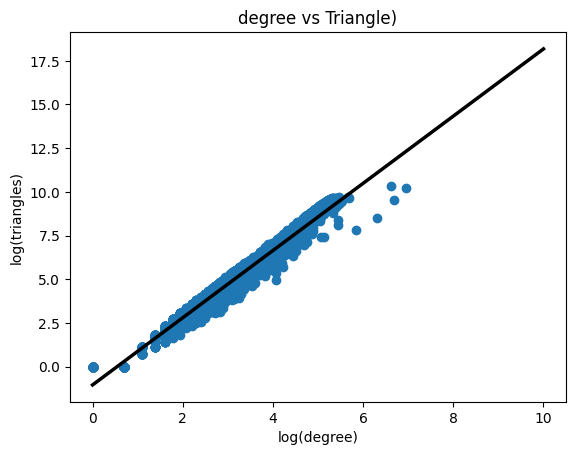

In [15]:
fb_graph = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
degrees=[]
triangles=[]
for node in fb_graph:
  degree=fb_graph.degree(node)
  degree=0 if degree<=1 else math.log(degree)
  triangle=nx.triangles(fb_graph,node)
  triangle=0 if triangle<=1 else math.log(triangle)
  degrees.append(degree)
  triangles.append(triangle)

degrees=np.array(degrees)
triangles=np.array(triangles)
plt.scatter(degrees,triangles)
plt.xlabel('log(degree)')
plt.ylabel('log(triangles)')
plt.title('degree vs Triangle)')
b, a = np.polyfit(degrees, triangles, deg=1)
print(b)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 10, num=80)

# Plot regression line
plt.plot(xseq, a + b * xseq, color="k", lw=2.5)
plt.show()